# Analysis

### Table of Contents

* [0.0 Data Preparation](#prep)
* [1.0 Comparative](#comp)
    * [1.1 Kullback–Leibler (KL) Divergence](#kl)
    * [1.2 Charts](#charts)
        * [1.2.1 Target Proportion](#prop)
        * [1.2.2 Target Distribution](#dist)
        * [1.2.3 Probability of Pick a Bad Loan](#proba)

In [1]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import project_utils as pu
import seaborn as sns
import warnings
from scipy.special import rel_entr

# Options
%matplotlib inline
pd.pandas.set_option('display.max_columns', None)
sns.set_style("white")
warnings.filterwarnings('ignore')

## 0.0 Data Preparation <a class="anchor" id="prep"></a>

In [2]:
# REPLICATION OF SAME TEST SET POPULATION

# Load the dataset into a pandas dataframe
df = pd.read_csv('./accepted_2007_to_2018Q4.csv',
                 encoding='utf-8',
                 na_values=[' ', 'ANY', 'NONE', 'OTHER'],
                 parse_dates=['issue_d', 'earliest_cr_line'],
                 skipinitialspace = True)

# Filter only records with information about completed loans
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]

# Encode target variable
target = {'Fully Paid' : 1,
          'Charged Off' : 0,
          'Default' : 0}

df['target'] = df['loan_status'].replace(to_replace=target)

# Filter only features of interest
df = df[['issue_d', 'grade', 'sub_grade', 'target']]

# Drop observations having more missing values than 90% null
df.dropna(axis=0, thresh=df.shape[1]*0.1, inplace=True)

# Impute 0 for numerical columns and 'na' for categorical features
df = df.fillna(0).fillna('na')

# Divide the data in train and test sets, with the test_set having the last 5% of the data (newest)
X_train, X_test, y_train, y_test = pu.train_test_split_sorted(X=df.drop(['target', 'issue_d'], axis=1),
                                                              y=df['target'],
                                                              test_size=0.05,
                                                              dates=df['issue_d'])

In [3]:
# Load the scores dataset into a pandas dataframe
df_rating= pd.read_csv('./output/scores.csv')

In [4]:
# Discretize scores generated by the new model into 7 categories 
# where "1" has highest scores and "7" lowest scores
labels = [7, 6, 5, 4, 3, 2, 1]
df_rating['nm_rating'] = pd.cut(df_rating.score, 7, precision=0, labels=labels)

# Encode original grades by lending platform into bins
grades = {'A' : 1,
          'B' : 2,
          'C' : 3,
          'D' : 4,
          'E' : 5,
          'F' : 6,
          'G' : 7}

df_rating['pf_grades'] = X_test['grade'].replace(to_replace=grades).reset_index(drop=True)

## 1.0 Comparative <a class="anchor" id="#comp"></a>

### 1.1 Kullback–Leibler (KL) Divergence  <a class="anchor" id="#kl"></a>

In [5]:
# Get probability density function of true paid loan - new model
bins = [1, 2, 3, 4, 5, 6, 7, 8]

pdf_model, bins_model = np.histogram(df_rating[df_rating['target'] == 1]['nm_rating'], bins=bins, density=True)

In [6]:
# Get probability density function of true paid loan - original platform
pdf_platform, bins_platform = np.histogram(df_rating[df_rating['target'] == 1]['pf_grades'], bins=bins, density=True)

In [7]:
# Calculate KL divergence score (PF || NM)
kl_pfnm = rel_entr(pdf_platform, pdf_model)
print('KL(P || NM): %.3f nats' % sum(kl_pfnm))
# calculate KL divergence score (NM || PF)
kl_nmpf = rel_entr(pdf_model, pdf_platform)
print('KL(NM || P): %.3f nats' % sum(kl_nmpf))

KL(P || NM): 0.321 nats
KL(NM || P): 0.339 nats


### 1.2 Charts  <a class="anchor" id="#charts"></a>

### 1.2.1 Target Proportion  <a class="anchor" id="#prop"></a>

In [8]:
# Show normalized target population by new model categories 
df_nm_norm = pd.crosstab(index=[df_rating['target']],
                         columns = [df_rating['nm_rating']],
                         normalize='columns',
                         ).T.apply(lambda x: x * 100)[::-1]
df_nm_norm

target,0,1
nm_rating,,
1,1.853842,98.146158
2,5.728653,94.271347
3,10.598938,89.401062
4,17.783103,82.216897
5,25.661800,74.338200
6,36.019647,63.980353
7,42.039356,57.960644


In [9]:
# Show normalized target population by platform original grades 
df_pf_norm = pd.crosstab(index=[df_rating['target']],
                         columns = [df_rating['pf_grades']],
                         normalize='columns').T.apply(lambda x: x * 100)
df_pf_norm

target,0,1
pf_grades,,
1,5.417140,94.582860
2,12.309035,87.690965
3,19.866877,80.133123
4,27.017784,72.982216
5,30.734842,69.265158
6,38.860759,61.139241
7,39.772727,60.227273


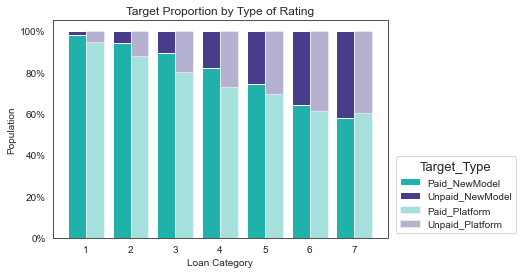

In [10]:
# Create the base axis to add the bars to
fig, ax = plt.subplots(1, 1, figsize = (6,4))

# Extract the labels
label = df_nm_norm.index

# Use this to create y ticks to add the data to
x = np.arange(len(label))

# Set a width for each bar 
width = 0.4

# Set it so that x will be the centre of the bars
# so set the centre of the first to be 1/2 width away to left and second to right
ax.bar(x - width / 2, df_nm_norm[1], width=width, label='Paid_NewModel', color='lightseagreen')
ax.bar(x - width / 2, df_nm_norm[0], width=width, label='Unpaid_NewModel', bottom=df_nm_norm[1], color='darkslateblue')

ax.bar(x + width / 2, df_pf_norm[1], width=width, label='Paid_Platform', color='lightseagreen', alpha=0.4)
ax.bar(x + width / 2, df_pf_norm[0], width=width, label='Unpaid_Platform', bottom=df_pf_norm[1], color='darkslateblue', alpha=0.4)

#set the ticks
ax.set_xticks(x)
ax.set_xticklabels(label)
ax.yaxis.set_major_formatter(mticker.PercentFormatter())

# Add the legend
ax.legend(title ="Target_Type", fontsize=10, title_fontsize=13, loc='lower right', bbox_to_anchor=(0.9, 0., 0.5, 0.5))

# Title
ax.set_title('Target Proportion by Type of Rating')
ax.set_xlabel('Loan Category')
ax.set_ylabel('Population')

plt.show()
fig.savefig('./output/target_proportion.png', bbox_inches='tight', dpi=600)

### 1.2.2 Target Distribution  <a class="anchor" id="#dist"></a>

In [11]:
# Show target population by new model categories 
df_nm = pd.crosstab(index=[df_rating['target']], columns=[df_rating['nm_rating']]).T[::-1]
df_nm

target,0,1
nm_rating,,
1,69,3653
2,581,9561
3,1736,14643
4,3191,14753
5,3199,9267
6,1980,3517
7,470,648


In [12]:
# Show target population by platform original grades 
df_pf = pd.crosstab(index=[df_rating['target']], columns = [df_rating['pf_grades']]).T
                                                     
df_pf

target,0,1
pf_grades,,
1,811,14160
2,2256,16072
3,3522,14206
4,3160,8536
5,1100,2479
6,307,483
7,70,106


In [13]:
# Filter by population of interest
df_pf_target1 = df_rating[['target', 'pf_grades']][df_rating['target'] == 1]
df_pf_target0 = df_rating[['target', 'pf_grades']][df_rating['target'] == 0]
df_nm_target1 = df_rating[['target', 'nm_rating']][df_rating['target'] == 1]
df_nm_target0 = df_rating[['target', 'nm_rating']][df_rating['target'] == 0]

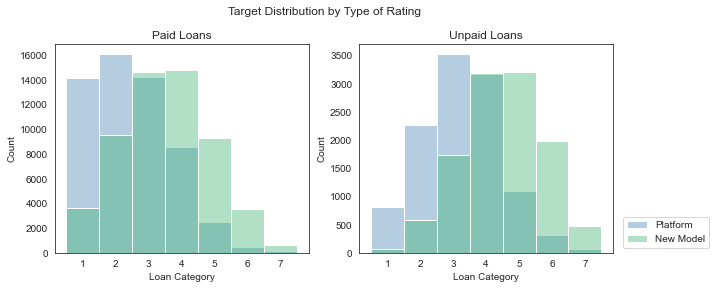

In [14]:
# Create the bases axis to add the charts to
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharex=True)

sns.histplot(df_pf_target1, x=df_pf_target1.pf_grades, discrete=True, alpha=0.4, color='steelblue', label='Platform', ax=ax[0])
sns.histplot(df_nm_target1, x=df_nm_target1.nm_rating, discrete=True, alpha=0.4, color='mediumseagreen', label='New Model', ax=ax[0])

sns.histplot(df_pf_target0, x=df_pf_target0.pf_grades, discrete=True, alpha=0.4, color='steelblue', label='Platform', ax=ax[1])
sns.histplot(df_nm_target0, x=df_nm_target0.nm_rating, discrete=True, alpha=0.4, color='mediumseagreen', label='New Model', ax=ax[1])

# Add overall title
fig.suptitle('Target Distribution by Type of Rating')
# Move overall title up
fig.subplots_adjust(top=.85)

# Add subtitles
ax[0].set_title('Paid Loans')
ax[1].set_title('Unpaid Loans')

# Add labels
ax[0].set_xlabel('Loan Category')
ax[1].set_xlabel('Loan Category')

# Add legend
plt.legend(loc='lower right', bbox_to_anchor=(0.9, 0., 0.5, 0.5))
plt.show()
fig.savefig('./output/target_distribution.png', bbox_inches='tight', dpi=600)

### 1.2.3 Probability of Pick a Bad Loan  <a class="anchor" id="#proba"></a>

In [15]:
# Calc the probability of pick a bad loan - new model
df_nm['proba_target0'] = round((df_nm[0] / (df_nm[0] + df_nm[1])) * 100, 2)
df_nm

target,0,1,proba_target0
nm_rating,,,
1,69,3653,1.85
2,581,9561,5.73
3,1736,14643,10.60
4,3191,14753,17.78
5,3199,9267,25.66
6,1980,3517,36.02
7,470,648,42.04


In [16]:
# Calc the probability of pick a bad loan - platform
df_pf['proba_target0'] = round((df_pf[0] / (df_pf[0] + df_pf[1])) * 100, 2)
df_pf

target,0,1,proba_target0
pf_grades,,,
1,811,14160,5.42
2,2256,16072,12.31
3,3522,14206,19.87
4,3160,8536,27.02
5,1100,2479,30.73
6,307,483,38.86
7,70,106,39.77


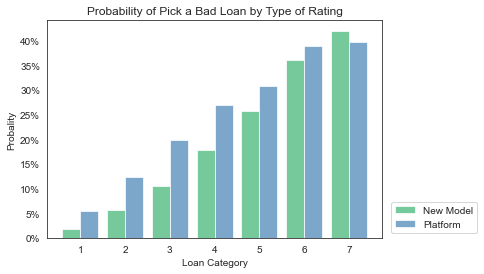

In [17]:
# Create the base axis to add the bars to
fig, ax = plt.subplots(1, 1, figsize = (6,4))

# Extract the labels
label = df_nm.index

# Use this to create y ticks to add the data to
x = np.arange(len(label))

# Set a width for each bar 
width = 0.4

# Set it so that x will be the centre of the bars
# so set the centre of the first to be 1/2 width away to left and second to right
ax.bar(x - width / 2, df_nm['proba_target0'], width=width, label='New Model', color='mediumseagreen', alpha=0.7)
ax.bar(x + width / 2, df_pf['proba_target0'], width=width, label='Platform', color='steelblue', alpha=0.7)

# Change y axis range
#ax.set_ylim([0, 50])

# Set the ticks
ax.set_xticks(x)
ax.set_xticklabels(label)

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mticker.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

# Add the legend
ax.legend(loc='lower right', bbox_to_anchor=(0.8, 0., 0.5, 0.5))

# Title
ax.set_title('Probability of Pick a Bad Loan by Type of Rating')
ax.set_xlabel('Loan Category')
ax.set_ylabel('Probality')

plt.show()
fig.savefig('./output/proba_unpaid.png', bbox_inches='tight', dpi=600)